<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/v5_bin_covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cat /etc/issue

Ubuntu 18.04.3 LTS \n \l



In [0]:
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Tesla P4
IRQ:   		 35
GPU UUID: 	 GPU-b4a72eca-d5d0-c6d4-e3e5-e58f4aa501c8
Video BIOS: 	 86.04.8c.00.10
Bus Type: 	 PCI
DMA Size: 	 47 bits
DMA Mask: 	 0x7fffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No


#Fazer



*   ***inicialzar pesos do kernel em todos os modelos = top_model = Dense(1024,activation='relu', kernel_initializate='he_normal')(top_model)***
*   ***re-treinar as camadas das redes pre treinadas***
*   ***arrumar dropout 0.3***
*   ***dataimagegeneration***
*   ***ReduceLROnPlateau***
*   ***confuzin and matrix = print(classification_report())***
*   Remover a categoria pneumonia


*   SKLearning para avaliar, matrix confuzion e tals
*   Voltar para 3 classes
*   Pedro: 
**  mudar para sgd
**  Mudar dataset
**  usar DenseNet121





#Head

In [0]:
version = '-v5-'

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

In [0]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(128, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.3)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

#assim ficou horrivel
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)

#Datasets

In [0]:
!mkdir '/content/drive/My Drive/UNICAMP/databases/covid19_v2'

mkdir: cannot create directory ‘/content/drive/My Drive/UNICAMP/databases/covid19_v2’: No such file or directory


In [0]:
%%shell
ls -lha '/content/drive/My Drive/UNICAMP/databases/covid19_v2/'

total 0


In [0]:
!rm -rvf '/content/drive/My Drive/UNICAMP/databases/covid19/chest_xray'
!rm -rvf '/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset'
!rm -rvf '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final'

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download paultimothymooney/chest-xray-pneumonia

unzip 'chest-xray-pneumonia.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19_v2/'

cd '/content/drive/My Drive/UNICAMP/databases/covid19_v2/'
git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [0]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [0]:
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/' #remove a pasta se ela ja existir

In [0]:
ls -lha '/content/drive/My Drive/UNICAMP/databases/covid19_v2/'

total 8.0K
drwx------ 7 root root 4.0K May  6 23:58 chest_xray/
drwx------ 8 root root 4.0K May  6 23:58 covid-chestxray-dataset/


In [0]:
#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/chest_xray/train/'
normal_xray = get_dataset(root+'NORMAL/', 'normal')
#pneumonia_xray = get_dataset(root+'PNEUMONIA/', 'pneumonia')
#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
df=pd.read_csv(metadata_path)
covid_patients=df['finding']=='COVID-19'
PA=df['view']=='PA'
PA_covid=df[covid_patients & PA]
covid_xray = [[srcpath + files, 'covid'] for files in PA_covid['filename']]
#print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
#random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(covid_xray))-1
dataset = normal_xray[0:min_size] + covid_xray[0:min_size]
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #pega % do treino e separa para teste
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/' #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/'+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    #print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 144
Classes: ['covid' 'normal']
--------------------------------------------------
Total de imagens= 288, 
Dados para: treino= 184, 
Validação= 46 
Teste= 58 
--------------------------------------------------
Total Y= 288, 
Dados para: Treino= 184, 
Validação= 46 
Teste= 58 


In [0]:
#split_dataset()

#Constantes

In [0]:
# Path to data
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'normal/'
covid_cases_dir = train_dir + 'covid/'

# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_train_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/train/covid')])
len_train_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/train/normal')])

len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])

len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])
print()
print("----"*10)
print("train : ", len_train_covid+len_train_normal)
print("test : ", len_test_covid+len_test_normal)
print("val : ", len_val_covid+len_val_normal)



----------------------------------------
train :  184
test :  58
val :  46


In [0]:
#parameters
num_classes = 2
img_rows, img_cols = 500, 500

train_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/train'
validation_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val'

nb_train_samples = len_train_covid + len_train_normal
nb_validation_samples = len_val_covid + len_val_normal

epochs = 100
batch_size = 16

models_loss = 'binary_crossentropy'
models_opt = Adam(lr=0.001)

In [0]:
#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 184 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


#Visualizando algumas amostras dos datasets

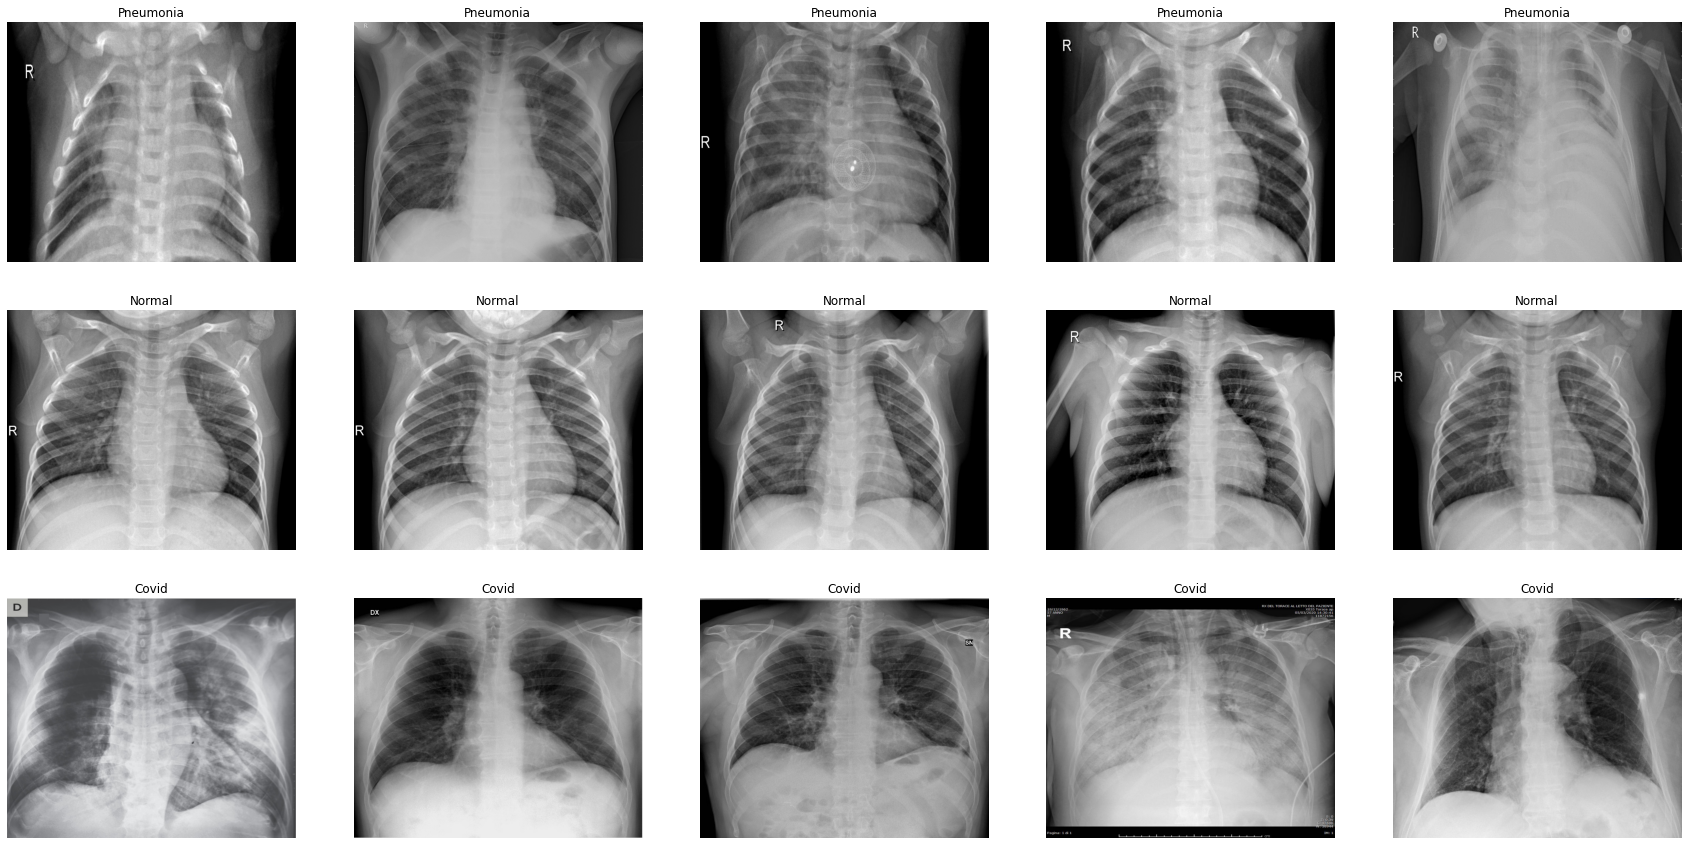

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

##ResNet50v2

234553344/234545216 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Epoch 1/100
11/11 [==============================] - 130s 12s/step - loss: 0.5367 - accuracy: 0.6964 - val_loss: 0.4686 - val_accuracy: 0.8438

Epoch 00001: val_loss improved from inf to 0.46858, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/ResNet152V2-v5-.h5
Epoch 2/100
11/11 [==============================] - 22s 2s/step - loss: 0.2038 - accuracy: 0.9375 - val_loss: 0.3110 - val_accuracy: 0.9333

Epoch 00002: val_loss improved from 0.46858 to 0.31098, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/ResNet152V2-v5-.h5
Epoch 3/100
11/11 [==============================] - 17s 2s/step - loss: 0.1347 - accuracy: 0.9494 - val_loss: 0.1395 - val_accuracy: 0.9667

Epoch 00003: val_loss improved from 0.31098 to 0.13952, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/ResNet152V2-v5-.h5
Epoch 4/100
11/11 [==============================] - 19s 2s/step - loss: 0.2703 - accuracy: 0.8949 - v

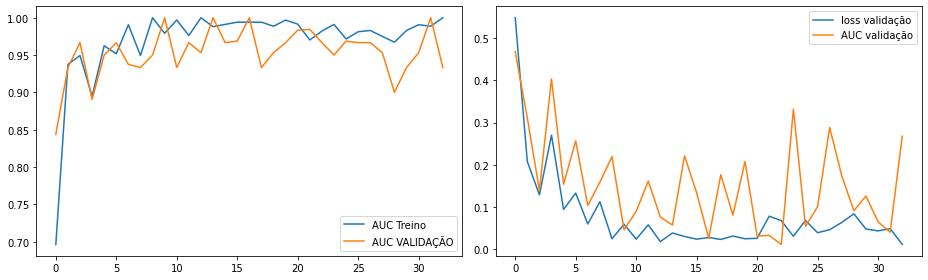

In [0]:
#ResNet152V2

ResNet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido, 1pb

for layer in ResNet152V2.layers:
  layer.trainable=False


FC = addTopModel(ResNet152V2, num_classes) #MobileNet = bottom_model
model = Model(input=ResNet152V2.input, output=FC) #bottom layers, top layer

#model.summary()

name_model = 'ResNet152V2'+version+'.h5'

checkpoint = ModelCheckpoint(data_dir+'ResNet152V2'+version+'.h5',
                            monitor='val_loss',
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
scores = history.history.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

#confuzin and matrix
#print(classification_report())

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##InceptionResNetv2

219062272/219055592 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 249, 249, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 249, 249, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 249, 249, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

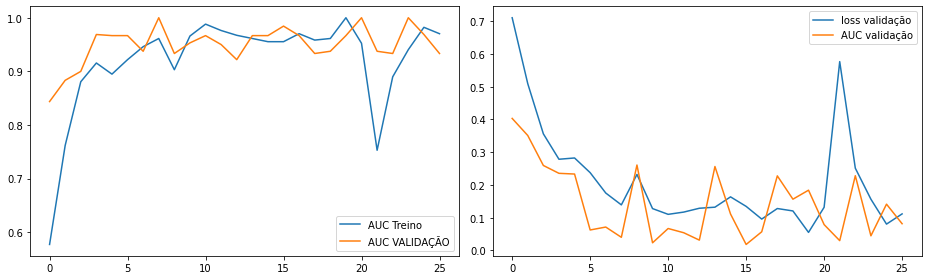



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#InceptionResNetV2
InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionResNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Inceptionv3

87916544/87910968 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 249, 249, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 249, 249, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 249, 249, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________________________

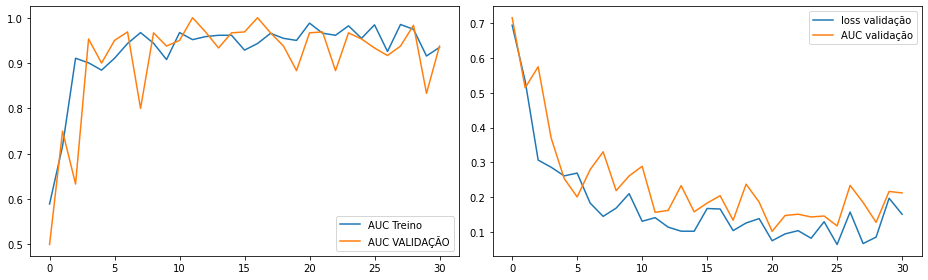



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#Inception2
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionV3'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet201

74842112/74836368 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 506, 506, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 250, 250, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

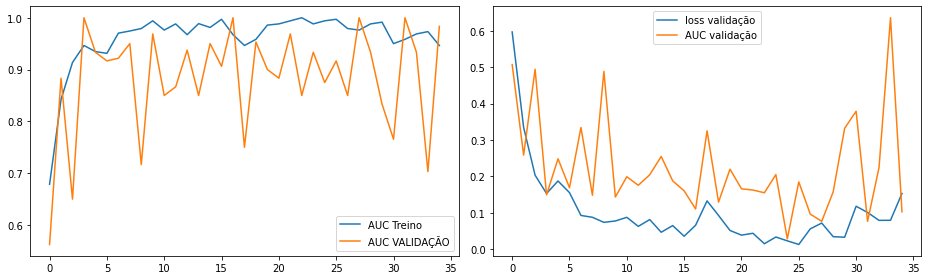



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#DenseNet201
DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet201'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##VGG19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
11/11 [==============================] - 150s 14s/step - loss: 0.7135 - accuracy: 0.5506 - val_loss: 0.6621 - val_accuracy: 0.7188

Epoch 00001: val_loss improved from inf to 0.66206, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/VGG19-v5-.h5
Epoch 2/100
11/11 [==============================] - 33s 3s/step - loss: 0.6930 - accuracy: 0.5446 - val_loss: 0.6129 - val_accuracy: 0.8833

Epoch 00002: val_loss improved from 0.66206 to 0.61285, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/VGG19-v5-.h5
Epoch 3/100
11/11 [==============================] - 15s 1s/step - loss: 0.6279 - accuracy: 0.6458 - val_loss: 0.5593 - val_accuracy: 0.8833

Epoch 00003: val_loss improved from 0.61285 to 0.55928, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/VGG19-v5-.h5
Epoch 4/100
11/11 [==============================] - 15s 1s/step - loss: 0.5931 - accuracy: 0.6815 - val_loss: 0.5360 - 

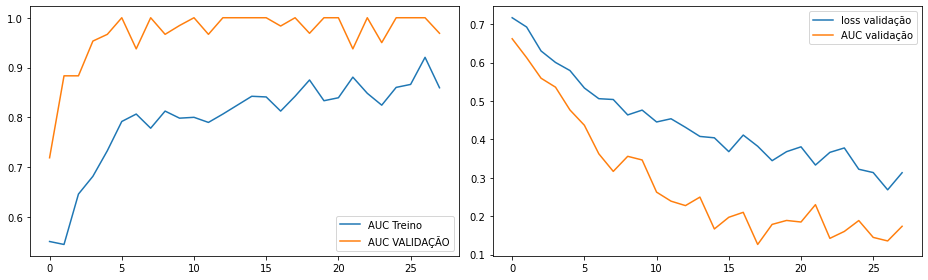

AttributeError: ignored

In [0]:
#VGG19
VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in VGG19.layers:
  layer.trainable=False

FC = addTopModel(VGG19, num_classes) #MobileNet = bottom_model
model = Model(input=VGG19.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'VGG19'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
scores = history.history.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##MobileNet

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
11/11 [==============================] - 18s 2s/step - loss: 0.5085 - accuracy: 0.7188 - val_loss: 0.6644 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.66436, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/MobileNetV2-v5-.h5
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 0.2765 - accuracy: 0.9137 - val_loss: 0.7617 - val_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 0.66436
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.1625 - accuracy: 0.9375 - val_loss: 0.5138 - val_accuracy: 0.7667

Epoch 00003: val_loss improved from 0.66436 to 0.51380, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/MobileNetV2-v5-.h5
Epoch 4/100
11/11 [==============================] - 15s 1s/step - loss: 0.2344 - accuracy: 0.9062 - val_loss: 0.4333 - val_accuracy: 0.6719

Epoch 00004: val_loss improved from 0.51380 to 0.43330, saving model 

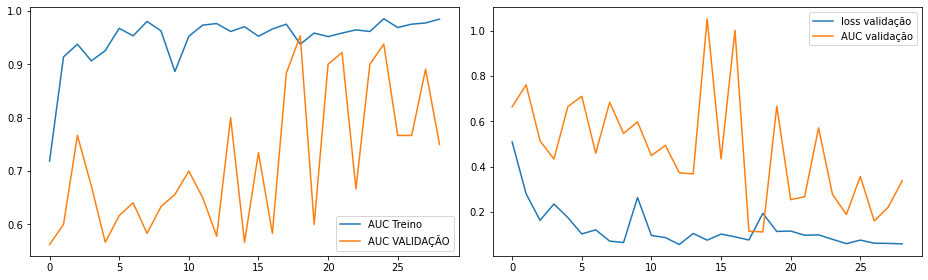

AttributeError: ignored

In [0]:
#MobileNetV2
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNetV2.layers:
  layer.trainable=False

FC = addTopModel(MobileNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'MobileNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
scores = history.history.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Xcepiton

83689472/83683744 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
11/11 [==============================] - 19s 2s/step - loss: 0.6286 - accuracy: 0.6488 - val_loss: 0.4680 - val_accuracy: 0.9531

Epoch 00001: val_loss improved from inf to 0.46800, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/Xception-v5-.h5
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 0.3665 - accuracy: 0.8661 - val_loss: 0.4923 - val_accuracy: 0.8667

Epoch 00002: val_loss did not improve from 0.46800
Epoch 3/100
11/11 [==============================] - 16s 1s/step - loss: 0.2716 - accuracy: 0.8864 - val_loss: 0.1376 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.46800 to 0.13760, saving model to /content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/Xception-v5-.h5
Epoch 4/100
11/11 [==============================] - 15s 1s/step - loss: 0.1648 - accuracy: 0.9406 - val_loss: 0.2264 - val_accuracy: 0.9375

Epoch 00004: val_loss did not improve from 0.13760
Epoch 5/100
11/11 [=====

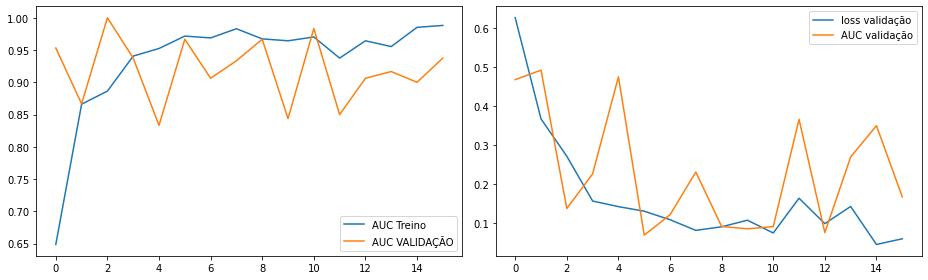

AttributeError: ignored

In [0]:
#Xception
Xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in Xception.layers:
  layer.trainable=False

FC = addTopModel(Xception, num_classes) #MobileNet = bottom_model
model = Model(input=Xception.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'Xception'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
scores = history.history.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##NASnet

In [0]:
#NASNetLarge
NASNetLarge = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in NASNetLarge.layers:
  layer.trainable=False

FC = addTopModel(NASNetLarge, num_classes) #MobileNet = bottom_model
model = Model(input=NASNetLarge.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('NASNetLarge'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

#Resultados

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))